In [199]:
import pandas as pd
from matplotlib import pyplot as plt
import settings
import numpy as np

## Model Data: 2014-2018
df = pd.read_csv(settings.ASSEMBLED_DIR + "\\Model_data.csv")

## TEST Data : Actuals 2019
df2 = pd.read_csv(settings.ASSEMBLED_DIR + "\\Test_data1.csv")


In [200]:
# Let us build model for Victoria
def series_data(df):
    demand = df.loc[df['STATE_VIC']==1, ['DATE_x', 'DEMAND']]
    demand.set_index(demand['DATE_x'], inplace = True)
    demand.drop(['DATE_x'], axis = 'columns', inplace = True)
    demand.sort_index(inplace=True)
    return demand

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

In [201]:
# Training
demand = series_data(df)
# Test
Y_test =series_data(df2)

# ARIMA MODEL

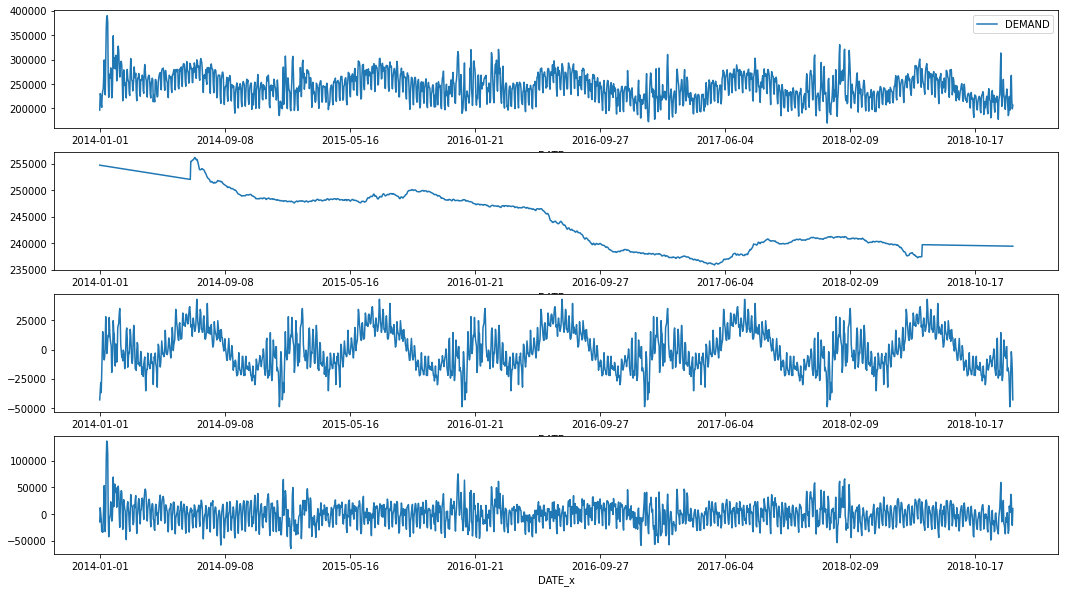

In [211]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
decomp = seasonal_decompose( x = demand,  model = 'additive', period= 365, extrapolate_trend = 365)
trends = decomp.trend
seasonals = decomp.seasonal
resids = decomp.resid

fig, axes = plt.subplots(4,1,  figsize= (18,10))
demand.plot(ax=axes[0])
trends.plot(ax=axes[1])
seasonals.plot(ax=axes[2])
resids.plot(ax=axes[3])

##### We can spot in trend (decreasing over time), mean is not constant over time

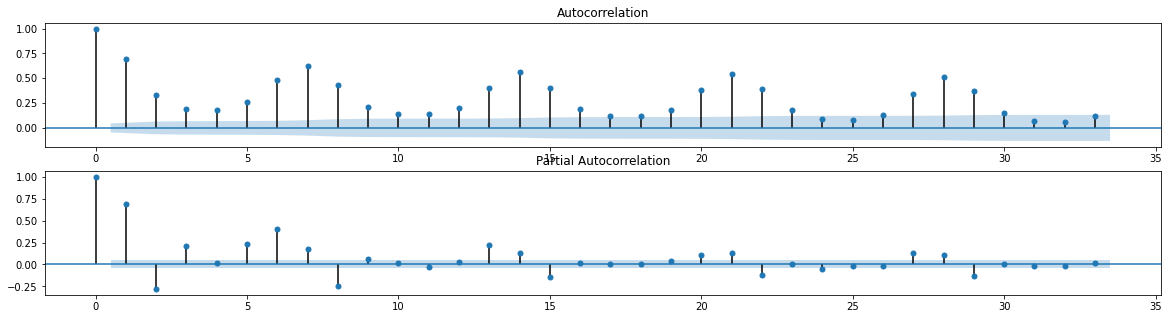

In [212]:
# Checking ACF and PACFs for data
fig, ax = plt.subplots(2, 1, figsize = (20,5))
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(demand, alpha=0.05, ax = ax[0])
tsa.plot_pacf(demand, alpha=0.05, ax = ax[1])
plt.show()

###### Interpretation
#Seasonality = 7 ( 7 days) and it is non-stationary, ACF shows values of autocorrelation stays large and positive


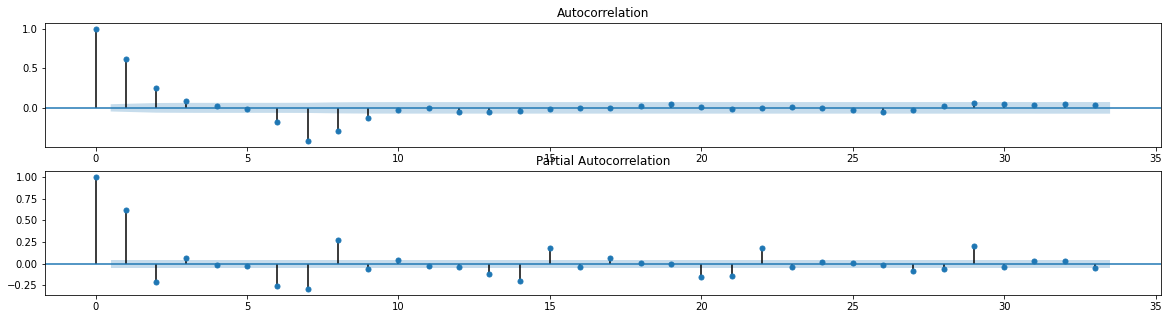

In [213]:
#We will use seasonal differencing with first difference 
diff_1 = demand.diff(periods = 7)
diff_1 = diff_1.dropna()
fig, ax = plt.subplots(2, 1, figsize = (20,5))
tsa.plot_acf(diff_1, alpha=0.05, ax = ax[0])
tsa.plot_pacf(diff_1, alpha=0.05, ax = ax[1])
plt.show()

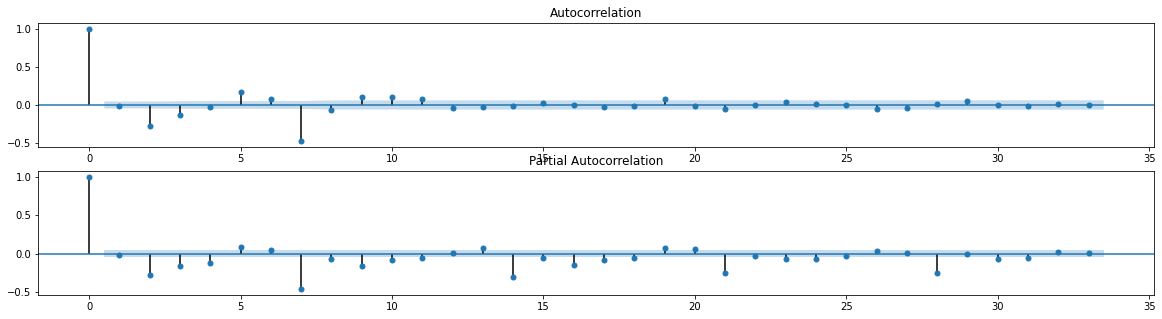

In [214]:
diff_2 = diff_1.diff()
diff_2 = diff_2.dropna()
fig, ax = plt.subplots(2, 1, figsize = (20,5))
tsa.plot_acf(diff_2, alpha=0.05, ax = ax[0])
tsa.plot_pacf(diff_2, alpha=0.05, ax = ax[1])
plt.show()

In [194]:
## Let us identify p,q,d and P,Q,D terms for the model
# There is significant autocorrelation at 7, 14, 21 days( shows weekened seasonality)
# There are 3 significant autocorrelations. and partial autocorrelation decay in damp sine wave manner
#p =3, q =3, d =1

#Seasonal ACF shows spike at 7, but no significant spikes.
#Seasonal PACF shows expoential decay in seasonal lags(P=1, Q=1, D=1)

In [218]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pmdarima as pm
# # Seasonal - fit stepwise auto-ARIMA

pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.AutoARIMA(test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=1,start_Q=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False))
])

pipeline.fit(demand)

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=11300.067, Time=0.18 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=10109.053, Time=2.43 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=10110.900, Time=5.44 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=10849.356, Time=0.89 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=10110.914, Time=5.66 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=10112.448, Time=18.55 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=10659.210, Time=1.95 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=10108.556, Time=9.90 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=10114.910, Time=12.68 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=11300.522, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=10110.166, Time=6.39 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=10112.004, Time=12.61 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=10850.317, Time=1.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=10112.020, Time=6.01 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=10113.549, Time=2

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('model',
                 AutoARIMA(D=1, d=1, error_action='ignore', m=7, max_p=3,
                           max_q=3, stepwise=False, suppress_warnings=True,
                           test='adf', trace=True))])

In [243]:
# parameters from model:
Sample_predictions= pipeline.predict_in_sample(exogenous=None, return_conf_int=False, alpha=0.05, inverse_transform=True)
Actuals = pd.Series.to_numpy(demand['DEMAND'])
Residuals = Actuals-Sample_predictions


C:\Users\raman\anaconda3\lib\site-packages\pmdarima\arima\arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


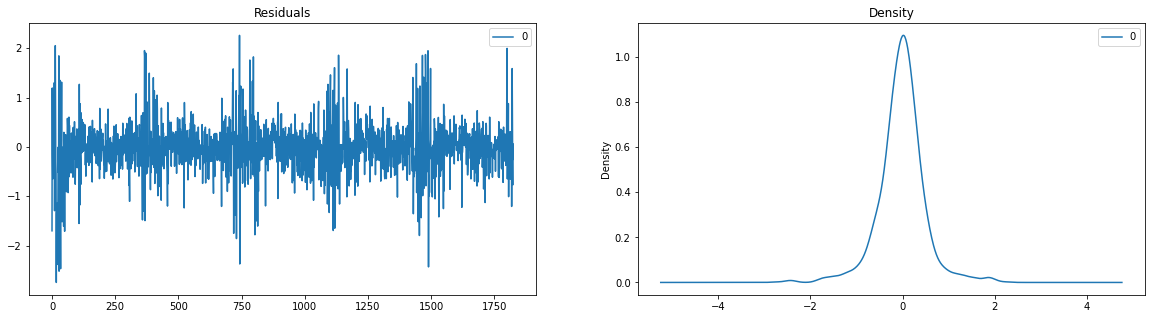

In [244]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

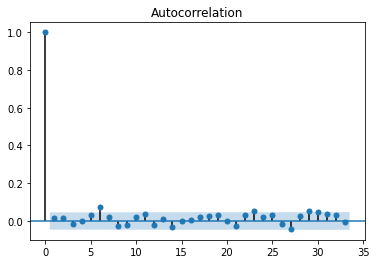

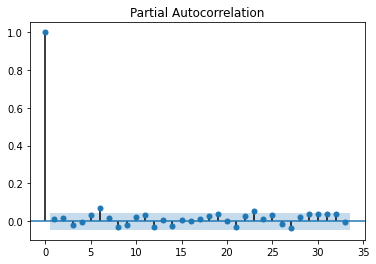

In [245]:
#Residuals ACF AND PACF look random noise
tsa.plot_acf(residuals, alpha=0.05)
tsa.plot_pacf(residuals, alpha=0.05)
plt.show()

### Model Evaluation & Performance

In [261]:
forecast_2019, conf_2019 = pipeline.predict(n_periods=365, return_conf_int=True,alpha=0.05, inverse_transform=True)
forecast_2019

array([215110.14407738, 224547.74357116, 228935.75751959, 225334.30604371,
       200742.54787656, 192504.34233527, 221072.35013198, 227222.04153943,
       228972.37537135, 229766.16368729, 225224.04844123, 200567.25690688,
       192387.16267934, 220980.72755238, 227140.88142086, 228892.81541175,
       229686.12218212, 225144.71085362, 200493.68664842, 192315.5764441 ,
       220902.21506933, 227060.92005533, 228812.44513703, 229605.56684132,
       225065.22053708, 200420.10778635, 192244.01151859, 220823.7260758 ,
       226980.97947835, 228732.09414155, 229525.03034613, 224985.74888359,
       200346.54690006, 192172.46433564, 220745.25566747, 226901.05765852,
       228651.76195121, 229444.51267759, 224906.29593198, 200273.00400759,
       192100.93489881, 220666.80384296, 226821.15459337, 228571.44856358,
       229364.01383343, 224826.86168002, 200199.47910674, 192029.42320592,
       220588.37060008, 226741.27028071, 228491.15397646, 229283.53381146,
       224747.44612553, 2

In [262]:
Actuals_2019 = pd.Series.to_numpy(Y_test['DEMAND'])

In [264]:
forecast_accuracy(forecast_2019, Actuals_2019)

{'mape': 0.09524995958452206,
 'me': -19777.669486770712,
 'mae': 23942.70788447959,
 'mpe': -0.07498502253525055,
 'rmse': 31454.054659827274,
 'corr': 0.4672418502930846}

#Interpetation
MAPE is 9.52%, Explanatory values may have more predicting power than time series model. let us explore more

In [268]:
#Visualization
df2 = pd.DataFrame(conf_2019, columns=['min', 'max'], index = Y_test.index)
df2['Mean'] = pd.DataFrame(forecast_2019, columns = ['mean'], index =Y_test.index )
df3 = df2[1:90]

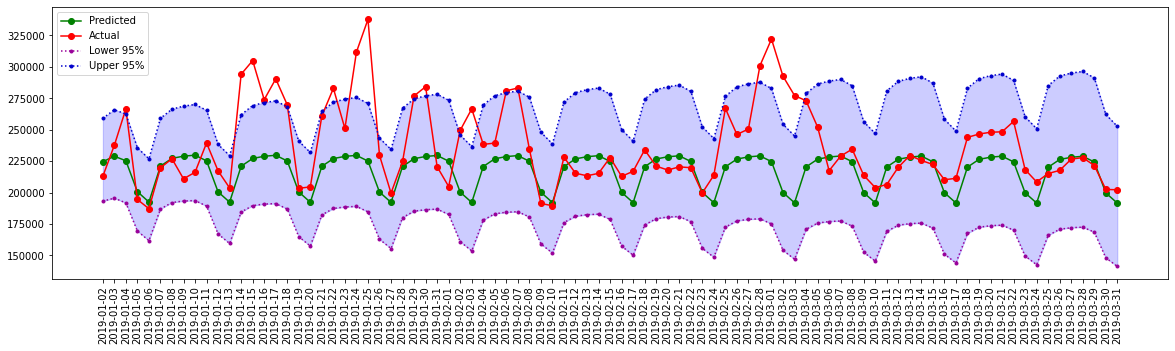

In [269]:
plt.figure(figsize=(20,5))
predicted, = plt.plot(Y_test[1:90].index, df3['Mean'], 'go-', label='Predicted')
actual, = plt.plot(Y_test[1:90].index, Y_test[1:90], 'ro-', label='Actual')
lower, = plt.plot(Y_test[1:90].index, df3['min'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
upper, = plt.plot(Y_test[1:90].index, df3['max'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(Y_test[1:90].index, df3['min'], df3['max'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])
plt.xticks(rotation=90)
plt.show()

# REGRESSION


In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [175]:
from sklearn.preprocessing import StandardScaler
def preprocess(df):
    
    ''' Keeps the columns needed to run the model
    Divide the data into labels and predictors'''
    
    df1 = df[["DEMAND","MAX_TEMP", "MIN_TEMP", "Holiday_Flag", "Weekened_Flag", "STATE_VIC"]]
    Data = df1.loc[df['STATE_VIC']==1, ["DEMAND","MAX_TEMP", "MIN_TEMP", "Holiday_Flag", "Weekened_Flag"]]
    Data.reset_index(inplace = True)
    X = Data.loc[:, ["MAX_TEMP", "MIN_TEMP", "Holiday_Flag", "Weekened_Flag"]]
    Y = Data["DEMAND"]
    
    scale = StandardScaler()
    
    X_scale = scale.fit_transform(X)
    return X_scale, Y

def rmse_score(X_test, Y_test):
    Y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    return rmse

def cross_val(model):
    scores = cross_val_score(model, X_train, Y_train, scoring ="neg_mean_squared_error", cv =10)
    rmse_scores = np.sqrt(-scores)
    m = rmse_scores.mean()
    std = rmse_scores.std()
    return m, std 

In [176]:
X_train, Y_train = preprocess(df)
X_test, Y_test = preprocess(df2)

In [177]:
#Linear Model
lin_reg = LinearRegression()
model = lin_reg.fit(X_train, Y_train)

In [178]:
# Rsquare Linear Model
model.score(X_train, Y_train)

0.3459222204407417

In [179]:
## Very poor predictor
## Let us check rmse
rmse_score(X_test, Y_test)

25106.564044445833

In [180]:
## Let us try Decision Tree
tree_reg = DecisionTreeRegressor()
model = tree_reg.fit(X_train, Y_train)
model.score(X_train, Y_train)

0.996228960197805

In [181]:
## R square looks good, let us check rmse on test data
rmse_score(X_test, Y_test)

22844.593770135856

In [182]:
## There is slight improvement in the rmse
## We can try ensemble methods
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
model = forest_reg.fit(X_train, Y_train)

In [183]:
cross_val(tree_reg)

(21607.24527754563, 878.6388446197792)

In [184]:
cross_val(forest_reg)

(16567.866601268146, 1085.3250825898979)

In [186]:
## There is improvement using random forest
## Let us use grid search to optimize the model
param_grid = [
    {'n_estimators': [3, 7], 'max_features':[2, 3, 4]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[1, 2, 3, 4]},
]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                          scoring = 'neg_mean_squared_error',
                          return_train_score= True)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 3, 4], 'n_estimators': [3, 7]},
                         {'bootstrap': [False], 'max_features': [1, 2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [187]:
grid_search.best_params_

{'max_features': 3, 'n_estimators': 7}

In [188]:
grid_search.best_estimator_

RandomForestRegressor(max_features=3, n_estimators=7)

In [189]:
cvres = grid_search.cv_results_

In [190]:
for mean_score, parmas in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),parmas)

18206.22201579876 {'max_features': 2, 'n_estimators': 3}
17315.643820045676 {'max_features': 2, 'n_estimators': 7}
18041.73066992788 {'max_features': 3, 'n_estimators': 3}
17264.920661361357 {'max_features': 3, 'n_estimators': 7}
18021.86889410412 {'max_features': 4, 'n_estimators': 3}
17379.503460511292 {'max_features': 4, 'n_estimators': 7}
18425.07330009336 {'bootstrap': False, 'max_features': 1, 'n_estimators': 3}
18099.032190011494 {'bootstrap': False, 'max_features': 1, 'n_estimators': 10}
18798.10272112305 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
18095.769659392758 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
19369.992294080508 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
18642.90147250333 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
21459.299031694827 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
21377.126574913662 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [191]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [192]:
cols = ["MAX_TEMP", "MIN_TEMP", "Holiday_Flag", "Weekened_Flag"]
sorted(zip(feature_importances, cols), reverse=True)

[(0.4398226306418505, 'MAX_TEMP'),
 (0.26668112839963254, 'Weekened_Flag'),
 (0.2315084147515492, 'MIN_TEMP'),
 (0.061987826206967724, 'Holiday_Flag')]

In [193]:
model = grid_search.best_estimator_

In [194]:
rmse_score(X_test,Y_test)

19063.85529871693

In [195]:
model.score(X_train, Y_train)

0.9278782954038105

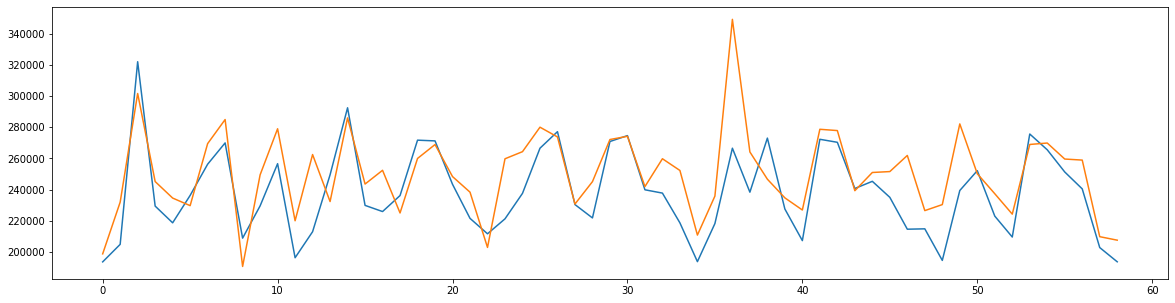

In [196]:
plt.figure(figsize=(20,5))
plt.plot(Y_test[0:59])
plt.plot(model.predict(X_test)[0:59])

In [197]:
forecast_accuracy(model.predict(X_test), Y_test)

{'mape': 0.06643827682441614,
 'me': 9703.208212654912,
 'mae': 15232.453662752774,
 'mpe': 0.044932971401438274,
 'rmse': 19063.85529871692,
 'corr': 0.8127708743108579}

### Arima with Regression variables 
######  Exogenous variables are used as additional features in the regression operation.


In [198]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pmdarima as pm
# # Seasonal - fit stepwise auto-ARIMA

pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.AutoARIMA(test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=1,start_Q=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False))
])

pipeline.fit(Y_train, exogenous=X_train)

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=13174.513, Time=1.34 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=12039.580, Time=3.77 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=12039.329, Time=10.66 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=12784.368, Time=1.68 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=12039.621, Time=4.80 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=12033.594, Time=10.45 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=12625.328, Time=4.59 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=12033.449, Time=11.22 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=12035.474, Time=14.07 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=12781.526, Time=2.64 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=11604.116, Time=5.39 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=11606.026, Time=7.85 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=12315.009, Time=5.75 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=11606.005, Time=5.80 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=11599.072, Time=

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('model',
                 AutoARIMA(D=1, d=1, error_action='ignore', m=7, max_p=3,
                           max_q=3, stepwise=False, suppress_warnings=True,
                           test='adf', trace=True))])

In [215]:
Sample_predictions= pipeline.predict_in_sample(exogenous=X_train, return_conf_int=False, alpha=0.05, inverse_transform=True)
Actuals = pd.Series.to_numpy(Y_train)
residuals = Actuals-Sample_predictions
Residuals = pd.Series(residuals)

C:\Users\raman\anaconda3\lib\site-packages\pmdarima\arima\arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


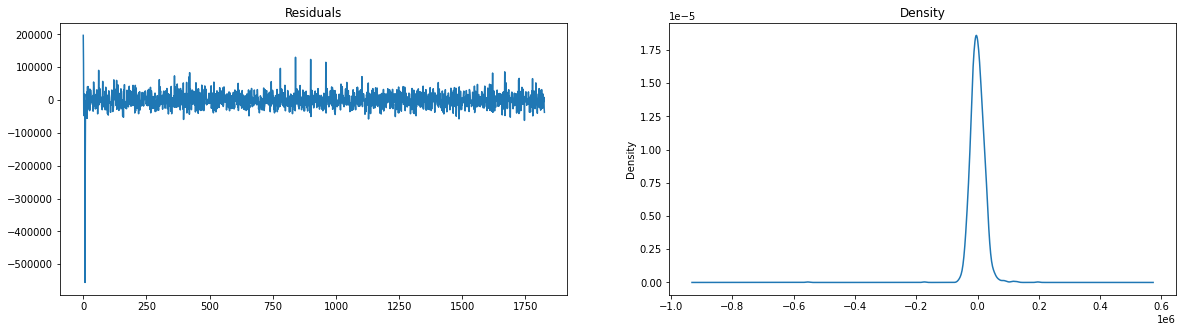

In [216]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
Residuals.plot(title="Residuals", ax=ax[0])
Residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [219]:
forecast_2019, conf_2019 = pipeline.predict(exogenous=X_test, n_periods=365, return_conf_int=True,alpha=0.05, inverse_transform=True)
forecast_2019

array([203293.03476468, 252068.44835726, 270453.28455652, 258729.34538092,
       256940.2166137 , 215969.58685808, 250068.61071435, 251575.8735159 ,
       219631.84991984, 260975.43599466, 261705.75144357, 218010.46456532,
       250977.43291127, 228708.56221023, 225524.77470367, 260603.7417494 ,
       253030.81566891, 218341.14415788, 252799.17096196, 248924.16043841,
       253271.68369908, 260041.80049714, 216966.40802105, 253799.9073291 ,
       260322.65839946, 229010.31671841, 223412.24456362, 259146.85579909,
       254134.04909908, 249612.37138662, 253387.92419103, 218467.14554604,
       255241.52422763, 258576.12610076, 220381.75156383, 255746.79437964,
       267145.19833328, 253215.52327267, 254738.12610527, 254555.8445593 ,
       216455.93004911, 250801.04346779, 252541.54424389, 216538.57598677,
       257183.91340927, 251485.61884287, 252498.56478567, 255263.99301674,
       218261.10310649, 255339.62841646, 253096.11358975, 260977.15390467,
       219419.04881831, 2

In [227]:
Actuals_2019 = pd.Series.to_numpy(Y_test['DEMAND'])
forecast_accuracy(forecast_2019, Actuals_2019)

{'mape': 0.11790653126096844,
 'me': 8427.832157635132,
 'mae': 27024.669386674945,
 'mpe': 0.0489803365405121,
 'rmse': 32325.153001197166,
 'corr': 0.07836937736680909}

In [235]:
# For productionizng model
# Out of five models( ARIMA, ARIMA with regressors, Linear Regression, DecisionTree, Random Forest)
# Random Forest performed best with 92% R-squared and rmse of 19063 on the test data data. So we will productionialize the 
# Random Forest Model.

model = grid_search.best_estimator_ 

import pickle
# Serialize with Pickle
with open('RandomForest.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)